In [35]:
import pandas as pd
import numpy as np
import re

In [57]:
df = pd.read_csv('NL_code_difference_clean.csv', na_values=['', 'nan'])
# df.info()

In [37]:
# n = 30
# for idx, row in enumerate(df['difference'].iloc[n:n+10]):
#     print(idx)
#     print(row)

In [58]:
# Drop rows with duplicate 'difference' but keep the first occurrence
df = df.drop_duplicates(subset=['Prompt'], keep='first')

# Check for NaN or empty strings in the original 'Prompt' column
df['difference'] = df['difference'].str.replace(r'\n+', ' ', regex=True).str.strip()

# print(df['difference'].isna().sum())  # Check for NaNs
# print(df['difference'].isnull().sum())  # Count of None values
# print((df['difference'] == '').sum())  # Check for empty strings

# Drop rows where 'difference' is an empty string
df = df[df['difference'].notna() & (df['difference'] != '')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 915 entries, 0 to 1094
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Prompt             915 non-null    object
 1   Answer             915 non-null    object
 2   ListOfCode         915 non-null    object
 3   conversation_id    915 non-null    object
 4   ClosedAt           346 non-null    object
 5   CreatedAt          915 non-null    object
 6   Number             915 non-null    int64 
 7   RepoLanguage       829 non-null    object
 8   RepoName           915 non-null    object
 9   State              915 non-null    object
 10  UpdatedAt          915 non-null    object
 11  conversationTitle  912 non-null    object
 12  issueDesc          893 non-null    object
 13  issueTitle         915 non-null    object
 14  mentionProperty    915 non-null    object
 15  mentionText        915 non-null    object
 16  numPrompts         915 non-null    int64 
 17  s

In [75]:
df_merged = df.groupby('conversation_id').agg({
    'difference': lambda x: ' '.join(x.dropna().astype(str)) if not x.dropna().empty else None,  # Avoid empty groups
    'State': 'first',    # Retain the first value of State (assumed to be the same for all prompts in a conversation)
    'numPrompts': 'first',  # Retain the first value of numPrompts
}).reset_index()

df_merged.info()
df = df_merged # CHANGE IF NEEDED

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   conversation_id  260 non-null    object
 1   difference       260 non-null    object
 2   State            260 non-null    object
 3   numPrompts       260 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 8.3+ KB


In [40]:
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from sklearn.cluster import KMeans
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Download required NLTK data
# # nltk.download('stopwords')
# # nltk.download('punkt')
# # nltk.download('punkt_tab')

# def create_custom_stopwords():
#     """Create custom stopwords list that preserves prompt structure words."""
#     stop_words = set(stopwords.words('english'))
    
#     # Words to keep for capturing prompt structure
#     structure_words = {
#         # Question words
#         'what', 'how', 'why', 'when', 'where', 'which',
#         # Modal verbs
#         'can', 'could', 'would', 'should',
#         # Common request verbs
#         'explain', 'show', 'tell', 'help', 'write', 'make', 'create',
#         # To-be verbs
#         'is', 'are', 'was', 'were',
#         # Pronouns
#         'i', 'you', 'it',
#         # Additional structural words
#         'do', 'does', 'did',
#         'this', 'that',
#         'mean', 'means',
#         'need', 'want'
#     }
    
#     # Convert the difference to a list
#     return list(stop_words - structure_words)

# def clean_text(text):
#     """Clean text by removing URLs, file paths, and code-specific terms."""
#     # Remove URLs
#     text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
#     # Remove file paths
#     text = re.sub(r'[a-zA-Z]:\\[\\\S|*\S]?.*|/\S+', '', text)
    
#     # Remove common code terms
#     code_terms = {
#         'github', 'com', 'http', 'https', 'localhost', 'api',
#         'json', 'xml', 'html', 'css', 'js', 'php', 'sql',
#         'readme', 'md', 'txt', 'pdf', 'doc', 'docx'
#     }
    
#     # Convert to lowercase and tokenize
#     tokens = word_tokenize(text.lower())
    
#     # Remove code terms and non-alphabetic tokens
#     tokens = [token.lemma_ for token in tokens 
#              if token.isalpha() and token.lower() not in code_terms]
    
#     return ' '.join(tokens)

# def cluster_prompts(df, column_name, n_clusters=5):
#     """
#     Cluster prompts using TF-IDF vectorization and K-means clustering.
    
#     Parameters:
#     df : pandas DataFrame containing the prompts
#     column_name : name of the column containing the prompts
#     n_clusters : number of clusters to create
    
#     Returns:
#     DataFrame with clusters and top words, cluster labels
#     """
#     # Clean the texts
#     df['cleaned_text'] = df[column_name].apply(clean_text)
    
#     # Create custom stopwords
#     custom_stops = create_custom_stopwords()
    
#     # Initialize TF-IDF vectorizer
#     tfidf_vectorizer = TfidfVectorizer(
#         ngram_range=(2, 4),  # Capture 2-4 word phrases
#         max_features=500, # best was 200 ?
#         min_df=0.01,  # Remove terms that appear in less than 1% of documents
#         max_df=0.7,   # Remove terms that appear in more than 70% of documents
#         stop_words=custom_stops
#     )
    
#     # Fit and transform the prompts
#     X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])
    
#     # Perform clustering
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     cluster_labels = kmeans.fit_predict(X_tfidf)
    
#     # Get top words for each cluster
#     feature_names = tfidf_vectorizer.get_feature_names_out()
#     cluster_centers = kmeans.cluster_centers_
    
#     # Store top words for each cluster
#     top_words_per_cluster = {}
#     n_top_words = 10
    
#     for i in range(n_clusters):
#         center_vector = cluster_centers[i]
#         top_indices = center_vector.argsort()[-n_top_words:][::-1]
#         top_words = [feature_names[idx] for idx in top_indices]
#         top_words_per_cluster[i] = top_words
    
#     return top_words_per_cluster, cluster_labels

In [83]:
import spacy
import re
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

def create_custom_stopwords():
    """Create custom stopwords list that preserves prompt structure words."""
    stop_words = set(stopwords.words('english'))
    
    # Words to keep for capturing prompt structure
    structure_words = {
        # Question words
        'what', 'how', 'why', 'when', 'where', 'which',
        # Modal verbs
        'can', 'could', 'would', 'should',
        # Common request verbs
        'explain', 'show', 'tell', 'help', 'write', 'make', 'create',
        # To-be verbs
        'is', 'are', 'was', 'were',
        # Pronouns
        'i', 'you', 'it',
        # Additional structural words
        'do', 'does', 'did',
        'this', 'that',
        'mean', 'means',
        'need', 'want'
    }
    
    # Convert the difference to a list
    return list(stop_words - structure_words)

def clean_text(text):
    """Clean text by removing URLs, file paths, and code-specific terms using SpaCy."""
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove file paths
    text = re.sub(r'[a-zA-Z]:\\[\\\S|*\S]?.*|/\S+', '', text)
    
    # Remove common code terms
    code_terms = {
        'github', 'com', 'http', 'https', 'localhost', 'api',
        'json', 'xml', 'html', 'css', 'js', 'php', 'sql',
        'readme', 'md', 'txt', 'pdf', 'doc', 'docx'
    }

    # Process the text with SpaCy
    doc = nlp(text.lower())  # Convert to lowercase and process with SpaCy
    
    # Lemmatize and filter tokens
    tokens = [
        token.lemma_ for token in doc 
        if token.is_alpha and token.text not in code_terms
    ]
    
    return ' '.join(tokens)

def cluster_prompts(df, column_name, n_clusters=5):
    """Cluster prompts using TF-IDF vectorization and K-means clustering."""
    # Clean the texts
    df['cleaned_text'] = df[column_name].apply(clean_text)
    
    # Create custom stopwords
    custom_stops = create_custom_stopwords()
    
    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        ngram_range=(2, 4),  # Capture 2-4 word phrases
        max_features=500,  # best was 200 ?
        min_df=0.01,  # Remove terms that appear in less than 1% of documents
        max_df=0.7,   # Remove terms that appear in more than 70% of documents
        stop_words=custom_stops
    )
    
    # Fit and transform the prompts
    X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])
    print(X_tfidf)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_tfidf)
    
    # Get top words for each cluster
    feature_names = tfidf_vectorizer.get_feature_names_out()
    cluster_centers = kmeans.cluster_centers_
    
    # Store top words for each cluster
    top_words_per_cluster = {}
    n_top_words = 10
    
    for i in range(n_clusters):
        center_vector = cluster_centers[i]
        top_indices = center_vector.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[idx] for idx in top_indices]
        top_words_per_cluster[i] = top_words
    
    return top_words_per_cluster, cluster_labels

In [84]:
# Perform clustering
top_words, labels = cluster_prompts(df, 'difference', 2)

# Print results
for cluster_id, words in top_words.items():
    print(f"\nCluster {cluster_id} top words:", ', '.join(words))

# Add cluster labels to DataFrame
df['cluster'] = labels

# show distribution of cluster labels
df['cluster'].value_counts()

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1828 stored elements and shape (260, 381)>
  Coords	Values
  (0, 163)	0.7914170096670649
  (0, 39)	0.6112766287121084
  (1, 294)	0.47367112215044443
  (1, 297)	0.5310636760620872
  (1, 161)	0.5310636760620872
  (1, 235)	0.459976534157541
  (2, 21)	0.3550919576363947
  (2, 372)	0.6485226122974596
  (2, 26)	0.673296459934873
  (3, 39)	0.39061564472644295
  (3, 161)	0.5057282594459684
  (3, 235)	0.43803246670986035
  (3, 125)	0.4069308790781752
  (3, 246)	0.48393508185854345
  (5, 39)	0.28721130552577406
  (5, 125)	0.2992075474105599
  (5, 99)	0.3718511421591332
  (5, 355)	0.35582708610571295
  (5, 203)	0.35582708610571295
  (5, 205)	0.35582708610571295
  (5, 109)	0.2120997521797331
  (5, 19)	0.3718511421591332
  (5, 306)	0.35582708610571295
  (6, 39)	0.33175409161341496
  (6, 319)	0.3958881964506027
  :	:
  (257, 115)	1.0
  (259, 39)	0.17296388099897944
  (259, 21)	0.22602547751941668
  (259, 99)	0.22393553270477076
  (259, 10

/Users/janeshen/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['it', 'should', 'that', 'you'] not in stop_words.
  warnings.warn(


cluster
1    182
0     78
Name: count, dtype: int64

/var/folders/1w/y2cbr0js165g3w970n3hbwqh0000gn/T/ipykernel_3979/1710834374.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='State', y='Count', data=cluster_data, ax=axes[i], palette='Set2')
/var/folders/1w/y2cbr0js165g3w970n3hbwqh0000gn/T/ipykernel_3979/1710834374.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='State', y='Count', data=cluster_data, ax=axes[i], palette='Set2')


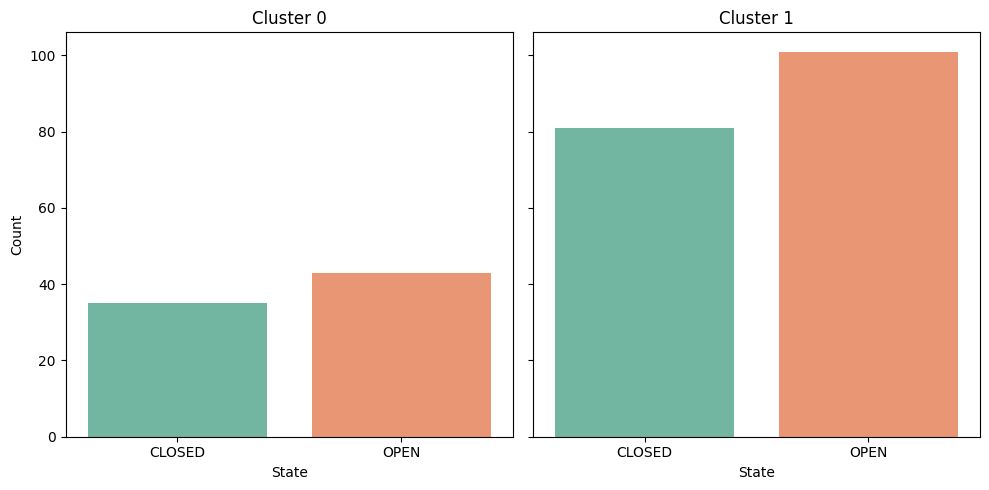

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate data: count occurrences of 'State' per 'cluster'
agg_data = df.groupby(['cluster', 'State']).size().reset_index(name='Count')

# Set up the plot
clusters = agg_data['cluster'].unique()
num_clusters = len(clusters)

# Create a grid of subplots based on the number of clusters
fig, axes = plt.subplots(1, num_clusters, figsize=(num_clusters * 5, 5), sharey=True)

# If there is only one cluster, axes will not be an array, so we need to handle that
if num_clusters == 1:
    axes = [axes]

# Plot each cluster
for i, cluster in enumerate(clusters):
    cluster_data = agg_data[agg_data['cluster'] == cluster]
    sns.barplot(x='State', y='Count', data=cluster_data, ax=axes[i], palette='Set2')
    axes[i].set_title(f"Cluster {cluster}")
    axes[i].set_xlabel('State')
    axes[i].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

# PREVIOUS DON'T TOUCH

In [10]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# CHANGE IF NEEDED
df = df_merged

# Function to extract structured features
def extract_dep_patterns(text):
    doc = nlp(text.lower())  # Process text with spaCy
    patterns = []
    
    for token in doc:
        if token.dep_ in {"aux", "advmod", "ROOT", "nsubj", "xcomp"}:
            patterns.append(f"{token.dep_}_{token.text}")  # Store dependency + word
    
    return " ".join(patterns)  # Convert list to space-separated string

# Apply feature extraction
df["dep_features"] = df["difference"].apply(extract_dep_patterns)

# Convert dependency patterns to numerical vectors
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["dep_features"])

# Perform clustering
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
df["cluster"] = kmeans.fit_predict(X)

# Get feature names from dependency vectorizer
feature_names = np.array(vectorizer.get_feature_names_out())

# Find the top words per cluster & show sample sentences
n_top_words = 10
for i in range(k):
    print(f"\n🔹 Cluster {i}:")

    # Get top dependency-based features
    top_indices = kmeans.cluster_centers_[i].argsort()[-n_top_words:][::-1]
    top_words = feature_names[top_indices]
    print(f"   Top words: {', '.join(top_words)}")

    # Show 5 example sentences from this cluster
    sample_sentences = df[df["cluster"] == i]["difference"].head(5).tolist()
    for idx, sentence in enumerate(sample_sentences, 1):
        print(f"   Example {idx}: {sentence}")


🔹 Cluster 0:
   Top words: nsubj_i, aux_to, aux_can, nsubj_you, nsubj_it, advmod_how, root_is, aux_do, nsubj_we, nsubj_that
   Example 1: Un java if I have a text block with 3 variables inside, how to replace the values? I have the following bash code I'd like to add a list of return codes that are succesful aside from 0 Also id like to compare the return coode to this list of codes and if the return code is contained in the list, mark the response as success What if I'd like to set the SUCCESS_CODES as an env var parameter
   Example 2: 8 DISCUSSION Optimization Expressiveness. The accelerators (e.g., GPUs and TPUs) usually have a hierarchical memory system and vector- or tensor-based computation engines. Both demand dedicated optimizations to achieve peak performance, and these optimizations are usually hard to be expressed through a series of loop transformations. The double buffering example we discussed in this paper is a good example of such a challenge. Instead of relying on a 

In [11]:
import spacy

# Load spaCy's large English model for tokenization
nlp = spacy.load('en_core_web_sm')

custom_stopwords = ['github', 'https', 'com', 'www', 'repository']

# Function to process each conversation's prompts
def tokenize(text):
    # Process the text with spaCy
    doc = nlp(text)
    
    # # Print tokens before filtering to debug
    # raw_tokens = [token.text for token in doc]
    # print(f"Raw tokens: {raw_tokens}")  # Debugging step
    
    # Extract tokens and filter out stopwords and punctuation # and not token.is_punct
    tokens = [token.text for token in doc]
    # tokens = [token.text for token in doc if not token.is_stop  and token.text.lower() not in custom_stopwords]
    # tokens = [token.text for token in doc if not token.is_stop or token.text == '?']

    # print(f"Filtered tokens: {tokens}")  # Debugging step
    
    return tokens

# Apply tokenization to each conversation
df = df_merged # CHANGE THIS IF NECESSARY
df['tokens'] = df['difference'].apply(tokenize)

In [319]:
n = 0
for row in df['tokens'].iloc[n:n+10]:
    print(row)
    print('-' * 50)

['Un', 'java', 'if', 'I', 'have', 'a', 'text', 'block', 'with', '3', 'variables', 'inside', ',', 'how', 'to', 'replace', 'the', 'values', '?', 'I', 'have', 'the', 'following', 'bash', 'code', '\n\n\n\n', 'I', "'d", 'like', 'to', 'add', 'a', 'list', 'of', 'return', 'codes', 'that', 'are', 'succesful', 'aside', 'from', '0', '\n', 'Also', 'i', 'd', 'like', 'to', 'compare', 'the', 'return', 'coode', 'to', 'this', 'list', 'of', 'codes', 'and', 'if', 'the', 'return', 'code', 'is', 'contained', 'in', 'the', 'list', ',', 'mark', 'the', 'response', 'as', 'success', 'What', 'if', 'I', "'d", 'like', 'to', 'set', 'the', 'SUCCESS_CODES', 'as', 'an', 'env', 'var', 'parameter']
--------------------------------------------------
['Analyze', 'this', 'repo', 'again', ':', 'https://github.com/AntonOsika/gpt-engineer.git', '.', ' ', 'But', 'this', 'time', 'focus', 'on', 'the', 'folder', ':', 'gpt_engineer', '.', ' ', 'Let', "'s", 'discuss', 'your', 'insights', 'in', 'a', 'step', 'by', 'step', 'way', '.', 

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the tokens back into string format for TF-IDF vectorizer
df['tokens_str'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(3, 4), max_features=100)  # (1, 2) for unigrams and bigrams

# Fit and transform the prompts into a TF-IDF matrix
X_tfidf = tfidf_vectorizer.fit_transform(df['tokens_str'])

0      Un java if I have a text block with 3 variable...
1      Analyze this repo again : https://github.com/A...
2           any mistakes in this : Ok what can you see ?
3      wow .   3 sounds awesome !   Let 's discuss st...
4                      give me a post with lots of words
                             ...                        
255              Is this Pressable API useful for this ?
256    and vite config to check if it has anything to...
257    how does omegle which uses webrtc detect if so...
258    should that OPENAI_CODE change on a per user b...
259    I am using the package react - native - image ...
Name: tokens_str, Length: 260, dtype: object


In [13]:
from sklearn.cluster import KMeans

# Apply KMeans clustering (set n_clusters=2 to separate questions and commands)
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_tfidf)

# Optionally: Add the cluster labels to the dataframe for further inspection
# df_merged['cluster_label'] = df_merged['cluster'].map({0: 'question', 1: 'statement'})

In [14]:
# Get the feature names (words) corresponding to each feature in the TF-IDF matrix
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Find the top words per cluster
n_top_words = 10
for i in range(k):
    top_indices = kmeans.cluster_centers_[i].argsort()[-n_top_words:][::-1]
    top_words = feature_names[top_indices]
    print(f"Cluster {i} top words: {', '.join(top_words)}")

Cluster 0 top words: what would be, what would be the, would be the, have access to, can you write, each of the, be able to, none of the, in order to, is it possible to
Cluster 1 top words: is it possible to, is it possible, it possible to, each of the, how to get, the best way, what would be the, do not have, have access to, what would be
Cluster 2 top words: https github com, what are the, what is the, show me how, step by step, the number of, do want to, so that it, be able to, how to run
Cluster 3 top words: what does this, does this mean, you show me, is it possible to, how to get, how to run, https github com, https github com antonosika, if it is, if you are
Cluster 4 top words: in order to, if you are, on the other, does this mean, it would be, would be the, you show me, is it possible to, how to run, https github com


In [301]:
# from sentence_transformers import SentenceTransformer
# from sklearn.cluster import KMeans
# import numpy as np

# # Load Sentence-BERT model
# model = SentenceTransformer('all-MiniLM-L6-v2')

# # Get embeddings for each conversation prompt
# embeddings = model.encode(df['difference'].tolist())

# # Perform KMeans clustering based on the embeddings
# k = 5
# kmeans = KMeans(n_clusters=k, random_state=42)  # Adjust the number of clusters based on your data
# kmeans.fit(embeddings)

# # Add cluster labels to the dataframe
# df['cluster_label'] = kmeans.labels_

# # Display the first 5 sentences for each cluster
# for i in range(k):  # Assuming you want two clusters: questions vs instructions
#     print(f"Cluster {i}:")
#     cluster_samples = df[df['cluster_label'] == i]['difference'].head(5)  # Get first 5 sentences of this cluster
#     for sentence in cluster_samples:
#         print("-" * 50)
#         print(sentence)
#     # print(cluster_samples.tolist())  # Print the sentences as a list
#     print("=" * 50)  # Add separator between clusters for better readability

In [236]:
from sklearn.metrics.pairwise import cosine_similarity

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate cosine similarity between each sentence's embedding and each cluster center
cosine_similarities = cosine_similarity(embeddings, cluster_centers)

# For each cluster, find the top 5 most similar sentences to the cluster center
for i in range(k):  # Assuming 2 clusters
    print(f"Cluster {i} top 5 most similar sentences: \n")
    
    # Get the indices of the sentences sorted by similarity to the cluster center (highest similarity first)
    top_indices = np.argsort(cosine_similarities[:, i])[::-1][:5]
    
    # Display the top 5 most similar sentences
    top_sentences = df.iloc[top_indices]['difference']
    for idx, sentence in zip(top_indices, top_sentences):
        print(f"Similarity: {cosine_similarities[idx, i]:.4f} - {sentence}")
        print("-" * 50)
    
    print("=" * 50)  # Separator for readability

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 384 while Y.shape[1] == 100